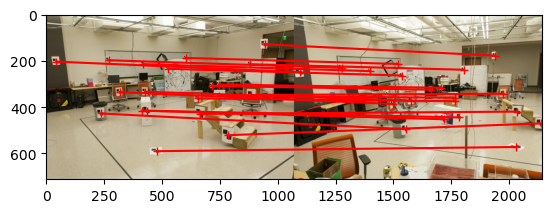

In [155]:
# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation
## Fundamental Matrix Estimation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

##
## load images and match files for the first example
##

def display_matches(I1, I2, matches):
    # this is a N x 4 file where the first two numbers of each row
    # are coordinates of corners in the first image and the last two
    # are coordinates of corresponding corners in the second image: 
    # matches(i,1:2) is a point in the first image
    # matches(i,3:4) is a corresponding point in the second image
    matches = matches
    N = len(matches)

    ##
    ## display two images side-by-side with matches
    ## this code is to help you visualize the matches, you don't need
    ## to use it to produce the results for the assignment
    ##

    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1
    I3[:,I1.size[0]:,:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3/256).astype(float))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    plt.show()

I1_lib = Image.open('MP4_part2_data/library1.jpg')
I2_lib = Image.open('MP4_part2_data/library2.jpg')
matches_lib = np.loadtxt('MP4_part2_data/library_matches.txt')

I1 = Image.open('MP4_part2_data/lab1.jpg')
I2 = Image.open('MP4_part2_data/lab2.jpg')
matches = np.loadtxt('MP4_part2_data/lab_matches.txt')

N = len(matches)
display_matches(I1, I2, matches)

In [156]:
a = np.array([[1,2],
              [3,4]])
print(a.mean(axis=1))
print(a-np.array([2,2]))

[1.5 3.5]
[[-1  0]
 [ 1  2]]


In [157]:
def fit_fundamental(matches, normalized = False):
    # matches(i,1:2) is a point in the first image
    # matches(i,3:4) is a corresponding point in the second image

    means = np.mean(matches,axis=0)
    m = matches-means
    msd = np.mean(np.sum(m[:,0:2]**2, axis=1))
    t = np.array([[1, 0, -means[0]],
                [0, 1, -means[1]],
                [0, 0, 1]])

    s = np.array([[1/np.sqrt(msd), 0, 0],
                [0, 1/np.sqrt(msd), 0],
                [0, 0, 1]])

    # Step 3: Create transformation matrix
    T = s @ t
    msd_ = np.mean(np.sum(m[:,2:4]**2, axis=1))
    t_ = np.array([[1, 0, -means[2]],
                    [0, 1, -means[3]],
                    [0, 0, 1]])

    s_ = np.array([[1/np.sqrt(msd_), 0, 0],
                    [0, 1/np.sqrt(msd_), 0],
                    [0, 0, 1]])

    # Step 3: Create transformation matrix
    T_ = s_ @ t_
    if normalized:
        h1 = np.hstack((matches[:, 0:2], np.ones((matches.shape[0],1))))
        m1 = T @ h1.T
        x = m1[0]
        y = m1[1]
        h2 = np.hstack((matches[:, 2:4], np.ones((N,1))))
        m2 = T_ @ h2.T
        x_= m2[0]
        y_= m2[1]
    else:
        x = matches[:, 0]
        y = matches[:, 1]
        x_= matches[:, 2]
        y_= matches[:, 3]
    A = np.array([x*x_, x_*y, x_, y_*x, y_*y, y_, x, y, np.ones(x.shape)]).T
    # print(A)
    U,S,V = np.linalg.svd(A)
    f_init = V[len(V)-1].reshape(3,3)

    U_,S_,V_ = np.linalg.svd(f_init)
    S_[2] = 0
    f = U_@(np.diag(S_))@V_

    if normalized:
        f = T_.T @ f @ T

    return f


Normalized: True
Residual: -2.9832551609238074


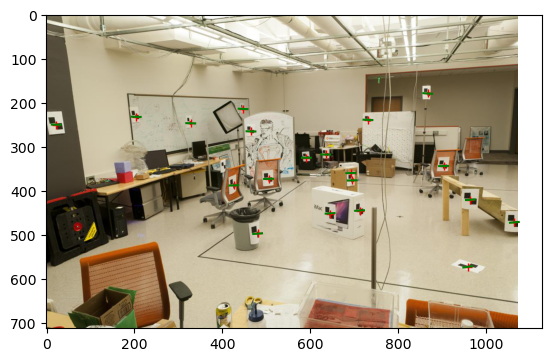

In [158]:
##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
normalized = True
F = fit_fundamental(matches,normalized) # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Normalized:",normalized)
print("Residual:", np.sum((matches[:,2:4]-closest_pt)))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(int))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()


In [159]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [160]:

## Camera Calibration

def camera_calibration(coord2d, coord3d):
    # Assuming you have 3D points (X, Y, Z) and corresponding 2D points (u, v)
    # Define your 3D points and their corresponding 2D points
    # Let's assume you have N correspondences

    u_homogeneous = np.hstack((coord2d, np.ones((N,1)))).T
    X_homogeneous = np.hstack((coord3d, np.ones((N,1)))).T

    # Construct matrix A
    A = np.zeros((2 * N, 12))
    for i in range(N):
        A[2*i, :4] = -X_homogeneous[:, i]
        A[2*i, 8:] = u_homogeneous[0, i] * X_homogeneous[:, i]
        A[2*i+1, 4:8] = -X_homogeneous[:, i]
        A[2*i+1, 8:] = u_homogeneous[1, i] * X_homogeneous[:, i]

    # Perform SVD on A
    _, _, V = np.linalg.svd(A)

    # Solution is the right singular vector corresponding to the smallest singular value
    P = V[-1, :].reshape((3, 4))

    return P

## Camera Centers
def camera_center(P):
    _, _, V = np.linalg.svd(P)

    C = V[len(V)-1]
    C /= C[3]
    return C


In [161]:
coord3d = np.loadtxt('MP4_part2_data/lab_3d.txt')

## Camera Calibration
P1 = camera_calibration(matches[:,0:2],coord3d)
print("Camera Projection Matrix 1:")
print(P1)
points_3d_proj, residual = evaluate_points(P1, matches[:,0:2], coord3d)
print("calibration residual:",residual)

P2 = camera_calibration(matches[:,2:4],coord3d)
print("Camera Projection Matrix 2:")
print(P2)
points_3d_proj, residual = evaluate_points(P2, matches[:,2:4], coord3d)
print("calibration residual:",residual)

## Camera Centers
C1= camera_center(P1)
print(C1)
C2= camera_center(P2)
print(C2)

P_library1 = np.loadtxt("MP4_part2_data/library1_camera.txt")
P_library2 = np.loadtxt("MP4_part2_data/library2_camera.txt")

C_library1= camera_center(P_library1)
C_library2= camera_center(P_library2)
print(C_library1)



Camera Projection Matrix 1:
[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]
calibration residual: 13.545832903514446
Camera Projection Matrix 2:
[[-6.93154686e-03  4.01684470e-03  1.32602928e-03  8.26700554e-01]
 [-1.54768732e-03 -1.02452760e-03  7.27440714e-03  5.62523256e-01]
 [-7.60946050e-06 -3.70953989e-06  1.90203244e-06  3.38807712e-03]]
calibration residual: 15.54495345362814
[305.83276769 304.20103826  30.13699243   1.        ]
[303.10003925 307.18428016  30.42166874   1.        ]
[  7.28863053 -21.52118112  17.73503585   1.        ]


In [168]:
## Triangulation
def triangulation(matches, P1, P2,N=N):
    u_homogeneous = np.hstack((matches[:,0:2], np.ones((N,1)))).T
    u_homogeneous2 = np.hstack((matches[:,2:4], np.ones((N,1)))).T
    Xs=[]
    # Construct matrix A
    for i in range(N):
        A = np.zeros((4, 4))
        A[0] = P1[0] - u_homogeneous[0, i]*P1[2]
        A[1] = P1[1] - u_homogeneous[1, i]*P1[2]
        A[2] = P2[0] - u_homogeneous2[0, i]*P2[2]
        A[3] = P2[1] - u_homogeneous2[1, i]*P2[2]

        # Perform SVD on A
        _, _, V = np.linalg.svd(A)

        # Solution is the right singular vector corresponding to the smallest singular value
        X = V[-1, :].reshape((1,4))
        Xs.append(X/X[:,3])
    Xs =np.array(Xs).reshape((N,4))[:,:3]
    return Xs

Xs_lab = triangulation(matches, P1, P2)
print("Lab:",Xs_lab)


Lab: [[312.76633579 309.14786576  30.08954076]
 [305.79390311 311.65059345  30.35669181]
 [307.69880468 312.36768107  30.41556936]
 [310.14745314 307.18221201  29.29913105]
 [311.95347749 310.12356629  29.21921786]
 [311.19518704 307.56962479  30.67673274]
 [307.10653102 306.87912386  28.65905456]
 [309.30922959 312.47237151  30.23133318]
 [307.43700637 310.14536182  29.31556412]
 [308.24874966 306.29640287  28.88412194]
 [306.64367428 309.29629569  28.90839211]
 [308.07119322 306.83748497  29.19053916]
 [309.6499804  308.81687582  29.03488811]
 [308.2579823  309.96091437  29.26422898]
 [307.55688637 308.6139455   28.96365681]
 [311.01395037 309.1888808   28.90769548]
 [307.52171373 308.18375315  29.06607832]
 [309.95928116 311.27093286  29.99108235]
 [312.17694452 310.78673917  29.07514099]
 [311.97128064 312.69472901  30.51545848]]


In [ ]:
print(coord3d)

[[312.747 309.14   30.086]
 [305.796 311.649  30.356]
 [307.694 312.358  30.418]
 [310.149 307.186  29.298]
 [311.937 310.105  29.216]
 [311.202 307.572  30.682]
 [307.106 306.876  28.66 ]
 [309.317 312.49   30.23 ]
 [307.435 310.151  29.318]
 [308.253 306.3    28.881]
 [306.65  309.301  28.905]
 [308.069 306.831  29.189]
 [309.671 308.834  29.029]
 [308.255 309.955  29.267]
 [307.546 308.613  28.963]
 [311.036 309.206  28.913]
 [307.518 308.175  29.069]
 [309.95  311.262  29.99 ]
 [312.16  310.772  29.08 ]
 [311.988 312.709  30.514]]


In [170]:
Xs_library = triangulation(matches_lib, P_library1, P_library2, len(matches_lib))
print("library:",Xs_library)

library: [[-7.40976706e-01 -1.45816492e-02  1.56111597e+01]
 [-1.17132841e+00  7.90154016e-02  1.27328903e+01]
 [-3.78833289e+00 -4.41071014e-01 -8.17874134e-01]
 [-3.76279191e+00 -1.96962851e-01 -4.58673422e-01]
 [ 1.24310881e-01 -4.72816771e-01  1.22102941e+01]
 [ 8.73911579e-01 -3.08193104e-01  1.55741686e+01]
 [ 1.08785728e-01 -4.50396754e-01  1.16446717e+01]
 [-1.95636806e+00 -4.58316222e-01  5.87749252e-01]
 [ 9.26716021e-02 -4.04779347e-01  9.88082408e+00]
 [ 1.52201533e+00 -2.62022706e-01  1.57246370e+01]
 [ 1.12060906e-01 -4.64131564e-01  8.15887887e+00]
 [ 1.83848731e+00 -1.16241287e-01  1.52613778e+01]
 [ 1.09246365e-01 -4.53160359e-01  5.00552725e+00]
 [ 1.80155422e+00 -1.73103472e-01  1.30148016e+01]
 [ 1.54026960e+00 -1.81919825e-01  3.89730473e+00]
 [ 2.66609336e+00 -1.07788883e-01  1.07179077e+01]
 [ 1.73123408e+00 -3.08630029e-01  3.11520601e+00]
 [ 1.79479845e+00 -2.13665880e-01  3.22462083e+00]
 [ 3.27509112e+00 -4.32930780e-01  9.87281161e+00]
 [ 4.82579913e+00 -3.2